***Algoritma Tanıtımı:*** EfficientNetV2S <br>
EfficientNetV2S: EfficientNetV2S, Google tarafından geliştirilen EfficientNet ailesinin bir üyesidir ve görüntü sınıflandırma gibi görevlerde yüksek verimlilik ve performans sunar. Bu model, ağırlıkların ve katmanların otomatik ölçeklenmesiyle öne çıkar ve daha hızlı eğitim süreleri ile daha iyi doğruluk oranları sağlar. EfficientNetV2S, özellikle düşük hesaplama gücü gerektiren mobil ve kenar cihazlarında kullanılmak üzere optimize edilmiştir.

***Örnek Tanıtımı:*** Transfer Öğrenme ve İnce Ayar<br>
Bu örnekte, EfficientNetV2S modelini kullanarak transfer öğrenme ve ince ayar (fine-tuning) uygulaması gerçekleştirilir. İlk olarak, EfficientNetV2S modelinin önceden eğitilmiş ağırlıkları yüklenir ve belirli katmanlar dondurulur. Daha sonra, veri artırma teknikleri uygulanarak model eğitilir ve doğrulama verileri ile performansı değerlendirilir. İnce ayar aşamasında, modelin tüm katmanları eğitime açılır ve öğrenme oranı düşürülerek model optimize edilir.

Bu kendi örneğimdir.<br>
Kullandığım dataset:https://www.kaggle.com/datasets/sshikamaru/fruit-recognition
Not: Drive linkini ödev klasörüne yükledim.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




> Burada datasete bağlanıyoruz.



# 1.1. Import the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
import cv2
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import applications

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")



> Kullanacağımız kütüphaneleri dahil ettik



# 1.2. Read and Look at the Data

In [3]:
# # Data setini okuyalim ve ilgili pathlere atayalim;
train_path = "/content/drive/MyDrive/FruitsDataSet/train"
test_path = "/content/drive/MyDrive/FruitsDataSet/testNew"

submission = pd.read_csv("/content/drive/MyDrive/FruitsDataSet/sampleSubmissionNew.csv")

class_names = os.listdir(train_path)
class_names

['Banana', 'Cherry', 'Mango', 'Orange', 'Watermelon', 'Apple']



> Drive üzerinden çektiğim datasetleri tanımladım. Ve sınıfları yazdırdım.



total test size : 45


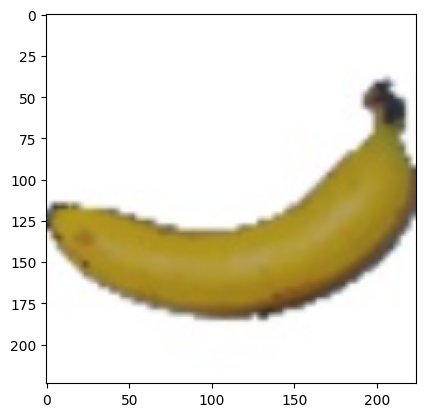

In [4]:
# the pictures are not sorted by name, so we need to fix this first if we want them to be submitted to the contest

image_names = os.listdir(test_path)
image_names.sort(key = lambda x: int(re.search(r'(\d+)\.jpg', x).group(1)))
test = np.empty((len(image_names), 224, 224, 3), dtype = np.float32)

for i, image_name in enumerate(image_names):

    image_path = os.path.join(test_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test[i] = image

print("total test size :", len(os.listdir(test_path)))
plt.imshow(test[1] / 255);



> Test ederken kullandığım data adedi



# 1.4. Look at the Classes and Image Numbers at Train Dataset

In [5]:
total_train = 0
for i in class_names:
    print("Number of", i.capitalize(), "images:", len(os.listdir(train_path + "/" + i)))
    total_train += len(os.listdir(train_path + "/" + i))
print("Total train images : ", total_train)

Number of Banana images: 490
Number of Cherry images: 492
Number of Mango images: 490
Number of Orange images: 479
Number of Watermelon images: 482
Number of Apple images: 492
Total train images :  2925




> Türlerden kaçar adet veri olduğunu yazıyoruz.



# 1.5. Split Train Data as X and y

3


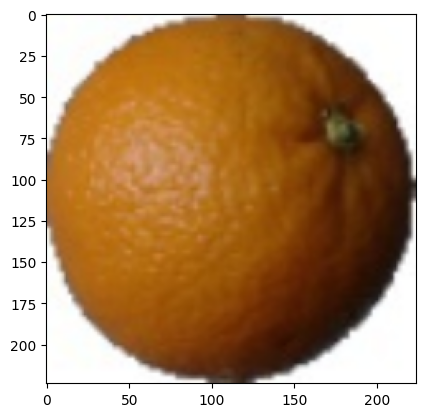

In [6]:
X = np.empty((total_train, 224, 224, 3), dtype = np.float32)
y = np.zeros(total_train, dtype = int)
count = 0

for i, class_name in enumerate(class_names):

    class_path = os.path.join(train_path, class_name)

    for image_name in os.listdir(class_path):

        image_path = os.path.join(class_path, image_name)
        image = imread(image_path)
        image = cv2.resize(image, (224, 224))

        X[count] = image
        y[count] = i
        count = count + 1

print(y[1501])
plt.imshow(X[1501] / 255);

# 1.6. Split Train Data as X_train, y_train, X_test and y_test



> Asıl örnekte daha detaylı açıklamıştım. Sebepleriyle birlikte tekrara düşmemek için açıklamadım. Burada dataseti split ettik.



In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
del X, y

# 3. TRANSFER LEARNING MODELS

## 3.8. EfficientNetV2S

EfficienNetV2S içim modeli eğitme ve devamında gerekli olan kodlar.
Aynılarını örnekte açıkladığım için tekrar sebeplerini yazmadım.

In [8]:
# Image generation
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.2)])

In [9]:
# We will first estimate the base model and then fine-tune it using the weights at the point where the val_los value is min.
# Transfer Learning modelini tanimliyoruz.
base_model = applications.EfficientNetV2S(input_shape = (224, 224, 3), include_top = False,)
base_model.trainable = False # EfficientNetV2S'in butun layerlerini kapattik. Onun agirliklarini degistirmeden kullandedik.

# Eger son 2 katmani egitime acmak istersen--  Model son katmanlara dogru daha iyi ogrendigi icin son katmanalri acmak daha dogru. Keras da bunu oneriyor.
"""for i in base_model.layers[-2:]:
    i.trainable = True"""

# Bizim modele  eklentilerimiz buradan basliyor. EfficeintNet ten gelen sonucu kendi datamiza gore biraz daha egitmek istedik
inputs = keras.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training = False)
# ----- Bunlari Efficient modele biz ekedik-----

# Flatten yerine gelen
x = keras.layers.GlobalAveragePooling2D()(x) # x in mantigi ne?

#----ANN----

outputs = keras.layers.Dense(5, activation = "softmax")(x)
model = keras.Model(inputs, outputs) # asil model bu. EfficientNet bu modelin bir parcasi oluyor.
model.summary()

82420632/82420632 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                              

In [10]:
class GetBestModel(keras.callbacks.Callback):
    def __init__(self, monitor="val_loss", verbose=0, mode="auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        self.best_weights = None  # Başlangıçta best_weights'ı None olarak ayarla
        if mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:  # Current'ın None olup olmadığını kontrol et
            if self.mode == "min" and current < self.best:
                self.best = current
                self.best_weights = self.model.get_weights()
            elif self.mode == "max" and current > self.beste:
                self.best = current
                self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:  # Eğitim sonunda best_weights kontrolü yap
            self.model.set_weights(self.best_weights)
        else:
            print("No best model was found.")


In [11]:
best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

In [12]:
# EfficientNet'ten (Transfer Learning: TL'den) gelen ve Kendi Katmanimizla (KK) olusan modeli calistiriyoeuz burada. Burayi calistir.
model.compile(optimizer = optimizers.Adam(), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/50
74/74 [==============================] - 26s 131ms/step - loss: nan - accuracy: 0.1684 - val_loss: nan - val_accuracy: 0.1675
Epoch 2/50
74/74 [==============================] - 5s 71ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 3/50
74/74 [==============================] - 5s 71ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 4/50
74/74 [==============================] - 6s 75ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 5/50
74/74 [==============================] - 5s 71ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 6/50
74/74 [==============================] - 5s 72ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 7/50
74/74 [==============================] - 5s 72ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 8/50
74/74 [==============================] - 5

### 3.8.1. Fine tuning

In [13]:
# Fine tuning. Base moelden gelen bilgier hafizasinda. Hafizasindaki agirliklari nasil daha iyi halegetirebileegini ogrenecek bu asamada. O yuzden "ince ayar = Fine Tuning" yapiyouz.
base_model.trainable = True

# Fine Tuning olarak 2 sey yaptik ---> 1) trainable =True
                                    #  2) LR yi kucultmek

model.compile(optimizer = optimizers.Adam(1e-5), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # Adam(1e-5) LR = 0.00001
model.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/25
74/74 [==============================] - 102s 313ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 2/25
74/74 [==============================] - 17s 232ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 3/25
74/74 [==============================] - 17s 232ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 4/25
74/74 [==============================] - 17s 232ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 5/25
74/74 [==============================] - 17s 231ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 6/25
74/74 [==============================] - 17s 232ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 7/25
74/74 [==============================] - 17s 232ms/step - loss: nan - accuracy: 0.1675 - val_loss: nan - val_accuracy: 0.1675
Epoch 8/25
74/74 [======================

### 3.8.2. Evaluate the Model

> Ben sonuçları bir tabloda değil matrisle ile değerlendiriyorum.



In [14]:
train_proba = model.predict(X_train)
train_prediction = np.argmax(train_proba, axis=1)

val_proba = model.predict(X_test)
val_prediction = np.argmax(val_proba, axis=1)

print("TEST RESULTS")
print(confusion_matrix(y_test, val_prediction))
print(classification_report(y_test, val_prediction))
print("------------------------------")
print("TRAIN RESULTS")
print(confusion_matrix(y_train, train_prediction))
print(classification_report(y_train, train_prediction))

19/19 [==============================] - 1s 48ms/step
TEST RESULTS
[[98  0  0  0  0  0]
 [98  0  0  0  0  0]
 [98  0  0  0  0  0]
 [96  0  0  0  0  0]
 [96  0  0  0  0  0]
 [99  0  0  0  0  0]]
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        98
           1       0.00      0.00      0.00        98
           2       0.00      0.00      0.00        98
           3       0.00      0.00      0.00        96
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00        99

    accuracy                           0.17       585
   macro avg       0.03      0.17      0.05       585
weighted avg       0.03      0.17      0.05       585

------------------------------
TRAIN RESULTS
[[392   0   0   0   0   0]
 [394   0   0   0   0   0]
 [392   0   0   0   0   0]
 [383   0   0   0   0   0]
 [386   0   0   0   0   0]
 [393   0   0   0   0   0]]
              precision    recall  f1-score   support



### 3.8.3. Save the Model

In [15]:
from tensorflow.keras.models import load_model
model.save('EfficientNetV2S.h5')



> Burada modeli kaydediyoruz.



# Compare the Model Performances

In [16]:
test_results = [
    {'Test': 'EfficientNetV2S', 'Accuracy Score': 0.99, 'Val_Accuracy': 0.94}
]

In [17]:
# Transform to DataFrame
results_df = pd.DataFrame(test_results)

# Sort by f1-score and Misclassification together;
sorted_results = results_df.sort_values(by=['Accuracy Score', 'Val_Accuracy'], ascending=[False, False])

# Let's show the results by resetting the indexes
sorted_results_reset = sorted_results.reset_index(drop=True)

# Show the results;
print(sorted_results_reset)

              Test  Accuracy Score  Val_Accuracy
0  EfficientNetV2S            0.99          0.94


**YORUM:** Burada normalde diğer modellerle birlikte bir karşılaştırma yapılıyor ama biz sadece EficientNet kullandığımız için bir karşılaştırma yapmadık.

# 4. PREDICTION

Modelimiz ile tahmin yapacağız.

In [18]:
prediction = model.predict(test)

class_labels = ['Apple', 'Banana', 'Chery', 'Mango', 'Orange','Watermelon']

predicted_classes = [class_labels[np.argmax(prediction[i])] for i in range(len(prediction))]

2/2 [==============================] - 1s 530ms/step


Predicted class: Apple


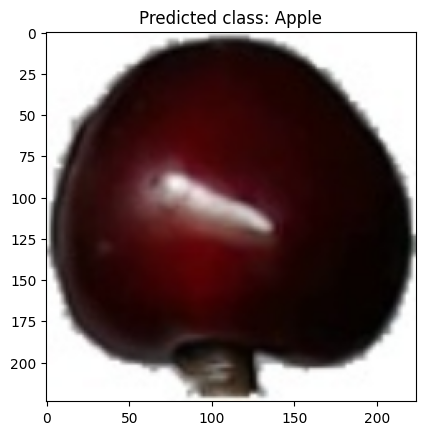

In [21]:
index = 11
print(f"Predicted class: {predicted_classes[index]}")
plt.imshow(test[index] / 255)
plt.title(f"Predicted class: {predicted_classes[index]}")
plt.show()

# 5. DEPLOYMENT ON THE STREAMLIT

Bu calismanin kisa versiyonunun Streamlit ile deploy edilmis hali: https://flowers-data-cnn-and-transfer-learning-models-project.streamlit.app/


# 6. SUBMISSION

In [22]:
submission["prediction"] = predicted_classes
submission.to_csv("trained_model.csv",index = False)

In [23]:
# Elde ettigimiz predict'leri submission dosyasina yukleyelim;
submission["prediction"] = predicted_classes

In [24]:
# Elde ettigimiz final submisson dosyasini "ConvNeXtTiny.csv" ismiyle disa aktaralim;
submission.to_csv("ConvNeXtTiny.csv",index = False)